# Estimate by modelization the evolution of Unemployment Rate in USA

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid')

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

## Definitions

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/UNRATE.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/CPIAUCSL.csv"


## Load data

- unemployment data :  https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm# 
    - less data :  https://fred.stlouisfed.org/series/UNRATE
- Interest rate :  https://fred.stlouisfed.org/series/FEDFUNDS
- INFLATION : https://www.usinflationcalculator.com/inflation/current-inflation-rates/
   - calculated from CPI : https://fred.stlouisfed.org/series/CPIAUCSL  
   Inflation = 100 * [ CPI(month, year) - CPI(month, year-1) ] / CPI(month, year-1)
- SPX SP500 : Yahoo Finance Ticker ^GSPC but history limited to 1985
  - So Use date copy paste table from  https://www.multpl.com/s-p-500-historical-prices/table/by-month if no update needed


In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
df_unemployment["DATE"] = pd.to_datetime(df_unemployment["DATE"])
df_unemployment.rename(columns={"UNRATE": "Total"}, inplace=True)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
df_rate["DATE"] = pd.to_datetime(df_rate["DATE"])
# load inflation
df_inflation = pd.read_csv(path_inflation)
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])

In [4]:

df_unemployment

,DATE,Total
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
915,2024-04-01,3.9
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
100 * (314.540 - 305.691) / 305.691

2.894753198491302

In [7]:
100*(190.9 - 185.0) / 185.0

3.189189189189192

In [8]:
# calculatate inflation
df_inflation["CPI-12"]= df_inflation["CPIAUCSL"].shift(12)
df_inflation["Inflation"] = 100 * (df_inflation["CPIAUCSL"] - df_inflation["CPI-12"]) / df_inflation["CPI-12"]
df_inflation.tail(20)

,DATE,CPIAUCSL,CPI-12,Inflation
911,2022-12-01,298.812,280.808,6.411498
912,2023-01-01,300.356,282.390,6.362123
913,2023-02-01,301.509,284.535,5.965523
914,2023-03-01,301.744,287.553,4.935090
915,2023-04-01,303.032,288.764,4.941059
916,2023-05-01,303.365,291.359,4.120690
917,2023-06-01,304.003,294.996,3.053262
918,2023-07-01,304.628,294.977,3.271781
919,2023-08-01,306.187,295.209,3.718721
920,2023-09-01,307.288,296.341,3.694055


In [9]:
df = df_unemployment.merge(df_inflation.filter(["DATE", "Inflation"]), on="DATE", how="left")

df.tail(12)

,DATE,Total,Inflation
908,2023-09-01,3.8,3.694055
909,2023-10-01,3.8,3.245787
910,2023-11-01,3.7,3.139482
911,2023-12-01,3.7,3.323160
912,2024-01-01,3.7,3.105981
913,2024-02-01,3.9,3.165743
914,2024-03-01,3.8,3.475131
915,2024-04-01,3.9,3.357731
916,2024-05-01,4.0,3.250210
917,2024-06-01,4.1,2.975629


In [10]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


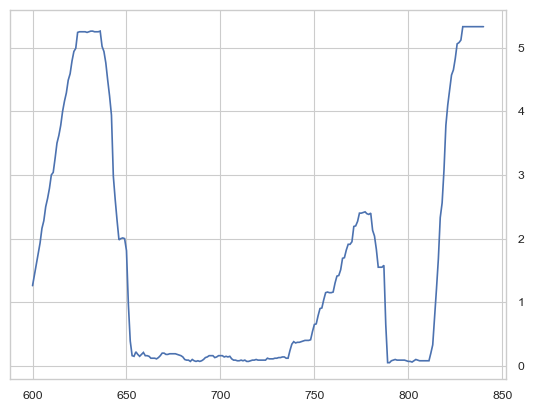

In [11]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [12]:
# add funds rate to df
df = df.merge(df_rate, on="DATE", how="left")
#df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df


,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [13]:
#df.dropna(inplace=True)
df 

,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [14]:
"""# check if nan into FEDFUNDS
assert df[df["FEDFUNDS"].isna()].shape[0] == 0
# find Nan value in inflation
assert  df[df["Inflation"].isna()].shape[0]==0"""

'# check if nan into FEDFUNDS\nassert df[df["FEDFUNDS"].isna()].shape[0] == 0\n# find Nan value in inflation\nassert  df[df["Inflation"].isna()].shape[0]==0'

In [15]:
# add do Df the indice SPX from yahoo finance ? 
# add the indice SPX from yahoo finance
date_start = df["DATE"].min().strftime("%Y-%m-%d")
date_end = df["DATE"].max().strftime("%Y-%m-%d")

updating = False
if updating:
    # check if data/SPX.csv exists and if last date is the last date of df
    if os.path.exists("data/SPX.csv"):
        df_spx = pd.read_csv("data/SPX.csv")
        last_date = df_spx["DATE"].max()
        if last_date >= date_end:
            print("SPX data is up to date")
            updating = False
        else:
            print("SPX data is not up to date")
            updating = True
    else:
        print("SPX data is not up to date")
        updating = True

    if updating:
        print("Updating...")
        df_spx = yf.Ticker("^GSPC").history(
                start=date_start, interval="1mo")
        df_spx = df_spx[["Close"]]
        df_spx["DATE"] = df_spx.index
        df_spx["DATE"] = df_spx["DATE"].dt.strftime("%Y-%m-%d")
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
        df_spx.to_csv("data/SPX.csv", index=False)
        print("SPX data is updated")
    else:
        df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
else:
    # read historical data
    df_spx = pd.read_csv("data/SP500_history.csv")
    # Rename the columns
    df_spx.rename(columns={"Date": "DATE", "Value": "Close"}, inplace=True)

    # Convert the date format and clean the 'Close' values by removing commas
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"], format="%b %d, %Y").dt.strftime("%Y-%m-%d")
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
    # sort by "DATE"
    df_spx.sort_values(by="DATE", inplace=True)
    df_spx["Close"] = df_spx["Close"].str.replace(",", "").astype(float)

# Display 
df_spx

,DATE,Close
1844,1871-01-01,4.44
1843,1871-02-01,4.50
1842,1871-03-01,4.61
1841,1871-04-01,4.74
1840,1871-05-01,4.86
...,...,...
4,2024-05-01,5235.22
3,2024-06-01,5415.14
2,2024-07-01,5538.00
1,2024-08-01,5478.21


In [16]:
df_tmp = df_spx.copy()
df_tmp["Close-12"] = df_tmp["Close"].shift(12)
df_tmp["SPX_diff"] = (df_tmp["Close"] - df_tmp["Close-12"]) / df_tmp["Close-12"]
df_spx = df_tmp
df_spx

,DATE,Close,Close-12,SPX_diff
1844,1871-01-01,4.44,NaN,NaN
1843,1871-02-01,4.50,NaN,NaN
1842,1871-03-01,4.61,NaN,NaN
1841,1871-04-01,4.74,NaN,NaN
1840,1871-05-01,4.86,NaN,NaN
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


In [17]:
df_spx.dropna()

,DATE,Close,Close-12,SPX_diff
1832,1872-01-01,4.86,4.44,0.094595
1831,1872-02-01,4.88,4.50,0.084444
1830,1872-03-01,5.04,4.61,0.093275
1829,1872-04-01,5.18,4.74,0.092827
1828,1872-05-01,5.18,4.86,0.065844
...,...,...,...,...
4,2024-05-01,5235.22,4146.17,0.262664
3,2024-06-01,5415.14,4345.37,0.246186
2,2024-07-01,5538.00,4508.08,0.228461
1,2024-08-01,5478.21,4426.24,0.237667


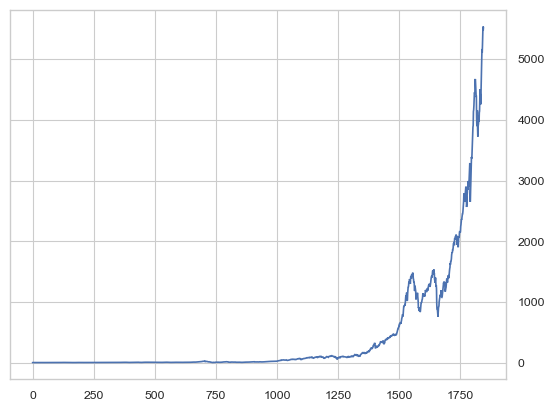

In [18]:
plt.plot(df_spx["Close"].values)

In [19]:
df = df.merge(df_spx.filter(["DATE","SPX_diff"]), how="left", on="DATE")
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
0,1948-01-01,3.4,10.242086,NaN,-0.024984
1,1948-02-01,3.8,9.481961,NaN,-0.107595
2,1948-03-01,4.0,6.818182,NaN,-0.056728
3,1948-04-01,3.9,8.272727,NaN,0.054795
4,1948-05-01,3.5,9.384966,NaN,0.126220
...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453
916,2024-05-01,4.0,3.250210,5.33,0.262664
917,2024-06-01,4.1,2.975629,5.33,0.246186
918,2024-07-01,4.3,2.923566,5.33,0.228461


In [20]:
df.dropna()

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
78,1954-07-01,5.8,0.261292,0.80,0.240428
79,1954-08-01,6.0,0.000000,1.22,0.259943
80,1954-09-01,6.1,-0.297508,1.07,0.351526
81,1954-10-01,5.7,-0.853432,0.85,0.342511
82,1954-11-01,5.3,-0.260708,0.83,0.364898
...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883
915,2024-04-01,3.9,3.357731,5.33,0.240453
916,2024-05-01,4.0,3.250210,5.33,0.262664
917,2024-06-01,4.1,2.975629,5.33,0.246186


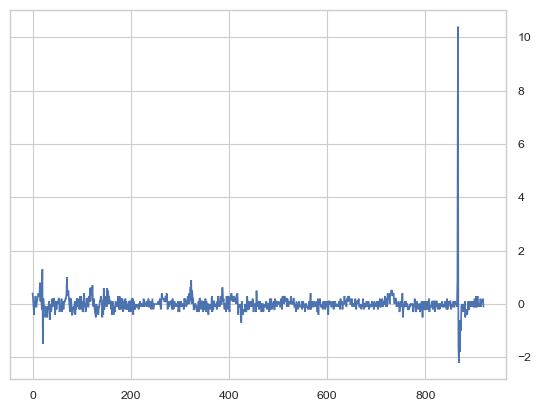

In [21]:
plt.plot(np.diff(df["Total"]))

In [22]:
# calculate next month diff in unemployment rate 
df["Total_diff"] = np.diff(df["Total"], append=np.nan)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1
...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1


In [23]:
ur_lower = df["Total_diff"] < 0
ur_higher = df["Total_diff"] > 0
ur_stable = df["Total_diff"] == 0
# add ur to df
df["ur_lower"] = ur_lower
df["ur_higher"] = ur_higher
df["ur_stable"] = ur_stable
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False


In [24]:
# function to convert from each str input (i.e: "July 2003") to just the number of the month (i.e: 7) 
def clean_month(str_month):
    return str_month[0:3] + " " + str_month[-4:]
#clean_month("July 2003")
#df["Month"] = df["Month"].apply(clean_month)

In [25]:
# convert df["Month"] into a number of the month
#df["date"] = pd.to_datetime(df["Month"], format="%b %Y")

In [26]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False


In [27]:
df["num_month"] = df["DATE"].dt.month

In [28]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month
0,1948-01-01,3.4,10.242086,NaN,-0.024984,0.4,False,True,False,1
1,1948-02-01,3.8,9.481961,NaN,-0.107595,0.2,False,True,False,2
2,1948-03-01,4.0,6.818182,NaN,-0.056728,-0.1,True,False,False,3
3,1948-04-01,3.9,8.272727,NaN,0.054795,-0.4,True,False,False,4
4,1948-05-01,3.5,9.384966,NaN,0.126220,0.1,False,True,False,5
...,...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6
918,2024-07-01,4.3,2.923566,5.33,0.228461,-0.1,True,False,False,7


In [29]:
# add last 3 month data about unemployment rate, inflation , fedfunds, SPX to df 
# as new columns (i.e: "Total-1", "Total-2", "Total-3")

df["Total-1"] = df["Total"].shift(1)
df["Total-2"] = df["Total"].shift(2)
df["Total-3"] = df["Total"].shift(3)

df["Inflation-1"] = df["Inflation"].shift(1)
df["Inflation-2"] = df["Inflation"].shift(2)
df["Inflation-3"] = df["Inflation"].shift(3)

df["fedfunds-1"] = df["FEDFUNDS"].shift(1)
df["fedfunds-2"] = df["FEDFUNDS"].shift(2)
df["fedfunds-3"] = df["FEDFUNDS"].shift(3)

df["spx-1"] = df["SPX_diff"].shift(1)
df["spx-2"] = df["SPX_diff"].shift(2)
df["spx-3"] = df["SPX_diff"].shift(3)

# diff : the difference between the current value and the previous value
df["Total-1_diff"] = df["Total"] - df["Total-1"]
df["Total-2_diff"] = df["Total-1"] - df["Total-2"]
df["Total-3_diff"] = df["Total-2"] - df["Total-3"] 

df["Inflation-1_diff"] = df["Inflation"] - df["Inflation-1"]
df["Inflation-2_diff"] = df["Inflation-1"] - df["Inflation-2"]
df["Inflation-3_diff"] = df["Inflation-2"] - df["Inflation-3"]

df["fedfunds-1_diff"] = df["FEDFUNDS"] - df["fedfunds-1"]
df["fedfunds-2_diff"] = df["fedfunds-1"] - df["fedfunds-2"]
df["fedfunds-3_diff"] = df["fedfunds-2"] - df["fedfunds-3"]


In [30]:
df.dropna(inplace=True)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,spx-3,Total-1_diff,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,0.240428,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,0.259943,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,0.351526,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,0.342511,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,0.364898,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,0.197494,-0.1,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,0.213053,0.1,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,0.228518,0.1,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,0.302883,0.1,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00


In [31]:
df.columns

Index(['DATE', 'Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable', 'num_month', 'Total-1', 'Total-2',
       'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3', 'fedfunds-1',
       'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3', 'Total-1_diff',
       'Total-2_diff', 'Total-3_diff', 'Inflation-1_diff', 'Inflation-2_diff',
       'Inflation-3_diff', 'fedfunds-1_diff', 'fedfunds-2_diff',
       'fedfunds-3_diff'],
      dtype='object')

In [32]:
"""list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3']"""

list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 
       'Total-1_diff', 'Total-2_diff', 'Total-3_diff', 
       'Inflation-1_diff', 'Inflation-2_diff', 'Inflation-3_diff',
       'fedfunds-1_diff', 'fedfunds-2_diff', 'fedfunds-3_diff', 
       'spx-1', 'spx-2', 'spx-3']
#df_x = df.filter(list_feat)
#df_x

## Target

Creation of a multi-class target : df_y["class"]

In [33]:
df["class"] = 0*df["ur_lower"] + 1*df["ur_stable"] + 2*df["ur_higher"] 
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-1_diff,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,0
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,0
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,0
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,0
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,-0.1,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,0.1,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,0.1,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,0.1,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2


In [34]:
df_y = df.filter(['Total_diff',
     'ur_lower', 'ur_higher', 'ur_stable', "class"])
df_y

,Total_diff,ur_lower,ur_higher,ur_stable,class
81,-0.4,True,False,False,0
82,-0.3,True,False,False,0
83,-0.1,True,False,False,0
84,-0.2,True,False,False,0
85,-0.1,True,False,False,0
...,...,...,...,...,...
914,0.1,False,True,False,2
915,0.1,False,True,False,2
916,0.1,False,True,False,2
917,0.2,False,True,False,2


In [35]:
list_targets = ["ur_lower", "ur_stable", "ur_higher"]

## Split Train / Test

In [36]:
ratio_test = 0.017
nb_test = int(df.shape[0] * (1 - ratio_test))
print("nb_test : ", nb_test)
#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)


nb_test :  823


In [37]:
df_train = df.iloc[:nb_test].copy()
df_test = df.iloc[nb_test:].copy()
df_train

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-1_diff,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,-0.4,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,0
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,-0.4,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,0
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,-0.3,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,0
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,-0.1,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,0
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,-0.2,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,2022-12-01,3.5,6.411498,4.10,-0.163086,-0.1,True,False,False,12,...,-0.1,0.0,0.1,-0.707968,-0.632475,-0.446331,0.32,0.70,0.52,0
900,2023-01-01,3.4,6.362123,4.33,-0.134059,0.2,False,True,False,1,...,-0.1,-0.1,0.0,-0.049375,-0.707968,-0.632475,0.23,0.32,0.70,2
901,2023-02-01,3.6,5.965523,4.57,-0.080320,-0.1,True,False,False,2,...,0.2,-0.1,-0.1,-0.396601,-0.049375,-0.707968,0.24,0.23,0.32,0
902,2023-03-01,3.5,4.935090,4.65,-0.096261,-0.1,True,False,False,3,...,-0.1,0.2,-0.1,-1.030432,-0.396601,-0.049375,0.08,0.24,0.23,0


In [38]:
df_test

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-1_diff,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class
904,2023-05-01,3.7,4.120690,5.06,0.026188,-0.1,True,False,False,5,...,0.3,-0.1,-0.1,-0.820370,0.005969,-1.030432,0.23,0.18,0.08,0
905,2023-06-01,3.6,3.053262,5.08,0.114497,-0.1,True,False,False,6,...,-0.1,0.3,-0.1,-1.067428,-0.820370,0.005969,0.02,0.23,0.18,0
906,2023-07-01,3.5,3.271781,5.12,0.152452,0.3,False,True,False,7,...,-0.1,-0.1,0.3,0.218519,-1.067428,-0.820370,0.04,0.02,0.23,2
907,2023-08-01,3.8,3.718721,5.33,0.064368,0.0,False,False,True,8,...,0.3,-0.1,-0.1,0.446941,0.218519,-1.067428,0.21,0.04,0.02,1
908,2023-09-01,3.8,3.694055,5.33,0.145066,0.0,False,False,True,9,...,0.0,0.3,-0.1,-0.024666,0.446941,0.218519,0.00,0.21,0.04,1
909,2023-10-01,3.8,3.245787,5.33,0.143028,-0.1,True,False,False,10,...,0.0,0.0,0.3,-0.448268,-0.024666,0.446941,0.00,0.00,0.21,0
910,2023-11-01,3.7,3.139482,5.33,0.138499,0.0,False,False,True,11,...,-0.1,0.0,0.0,-0.106306,-0.448268,-0.024666,0.00,0.00,0.00,1
911,2023-12-01,3.7,3.323160,5.33,0.197494,0.0,False,False,True,12,...,0.0,-0.1,0.0,0.183678,-0.106306,-0.448268,0.00,0.00,0.00,1
912,2024-01-01,3.7,3.105981,5.33,0.213053,0.2,False,True,False,1,...,0.0,0.0,-0.1,-0.217179,0.183678,-0.106306,0.00,0.00,0.00,2
913,2024-02-01,3.9,3.165743,5.33,0.228518,-0.1,True,False,False,2,...,0.2,0.0,0.0,0.059762,-0.217179,0.183678,0.00,0.00,0.00,0


In [39]:
df_train["TRAIN"] = 1
df_test["TRAIN"] = 0
df = pd.concat([df_train, df_test], axis=0)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class,TRAIN
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,0,1
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,0,1
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,0,1
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,0,1
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2,0
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2,0
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2,0
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2,0


### Check features repart

#### Check Out of range
check if Test out of Train range for each features

In [40]:
df_min = df.filter(list_feat).groupby(df["TRAIN"]).min().transpose()
df_min["feat"] = df_min.index
df_min["out_min"] = df_min[0] < df_min[1]
df_min["pc_out_min"] = df_min["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] <  df[df["TRAIN"] == 1][x].min()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_min

TRAIN,0,1,feat,out_min,pc_out_min
Total,3.500000,3.400000,Total,False,0.0
Inflation,2.923566,-1.958761,Inflation,False,0.0
FEDFUNDS,5.060000,0.050000,FEDFUNDS,False,0.0
SPX_diff,0.026188,-0.425084,SPX_diff,False,0.0
num_month,1.000000,1.000000,num_month,False,0.0
Total-1_diff,-0.100000,-2.200000,Total-1_diff,False,0.0
Total-2_diff,-0.100000,-2.200000,Total-2_diff,False,0.0
Total-3_diff,-0.100000,-2.200000,Total-3_diff,False,0.0
Inflation-1_diff,-1.067428,-2.631140,Inflation-1_diff,False,0.0
Inflation-2_diff,-1.067428,-2.631140,Inflation-2_diff,False,0.0


In [41]:
df_max = df.filter(list_feat).groupby(df["TRAIN"]).max().transpose()
df_max["feat"] = df_max.index
df_max["out_max"] = df_max[0] > df_max[1]
df_max["pc_out_max"] = df_max["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] >  df[df["TRAIN"] == 1][x].max()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_max

TRAIN,0,1,feat,out_max,pc_out_max
Total,4.300000,14.800000,Total,False,0.0
Inflation,4.120690,14.592275,Inflation,False,0.0
FEDFUNDS,5.330000,19.100000,FEDFUNDS,False,0.0
SPX_diff,0.302883,0.526508,SPX_diff,False,0.0
num_month,12.000000,12.000000,num_month,False,0.0
Total-1_diff,0.300000,10.400000,Total-1_diff,False,0.0
Total-2_diff,0.300000,10.400000,Total-2_diff,False,0.0
Total-3_diff,0.300000,10.400000,Total-3_diff,False,0.0
Inflation-1_diff,0.446941,2.138555,Inflation-1_diff,False,0.0
Inflation-2_diff,0.446941,2.138555,Inflation-2_diff,False,0.0


In [42]:
df_min.at["Total", 1]

3.4

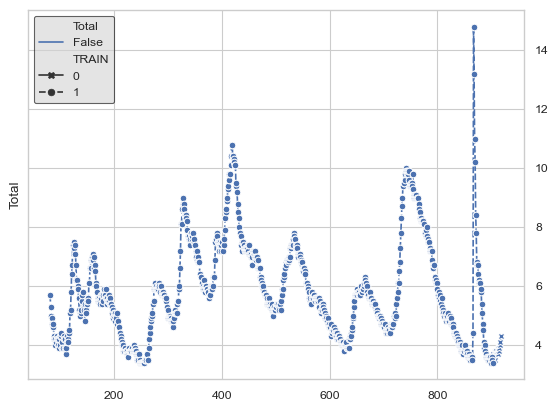

In [43]:
# detect unemployment rate < in test set
markers = {0: "X", 1: "o"}
ax = sns.lineplot(df.index.values, 
                df["Total"], hue=df["Total"] > df_max.at["Total", 1] , 
                style=df["TRAIN"], 
                markers=markers)
sns.move_legend(ax, "best", facecolor="lightgrey")

[Text(0.0, 1.0, 'Detect Inflation test > max TRAIN set')]

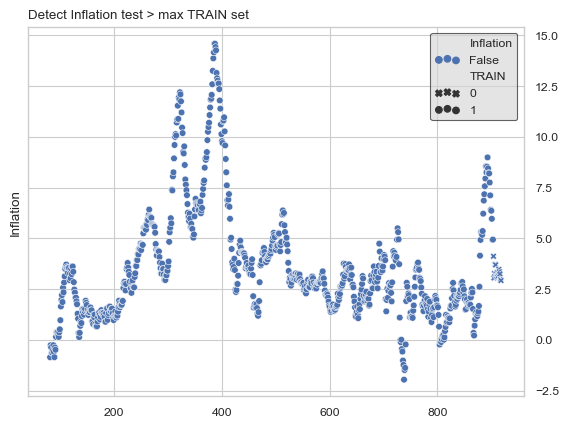

In [44]:
# detect FEDFUNDS > in test set

markers = {0: "X", 1: "o"}
ax = sns.scatterplot(df.index.values, 
                df["Inflation"], 
                hue=df["Inflation"] > df_max.at["Inflation", 1], 
                style=df["TRAIN"], 
                markers=markers)
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect Inflation test > max TRAIN set")

[Text(0.0, 1.0, 'Detect FEDFUNDS test > max TRAIN set')]

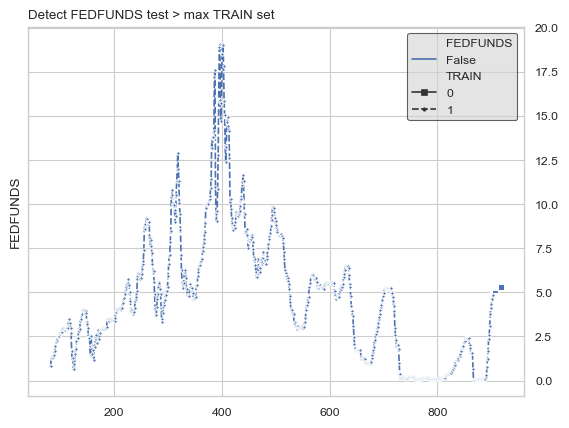

In [45]:
# detect FEDFUNDS > in test set

markers = {0: "s", 1: "."}
ax = sns.lineplot(df.index.values, 
                df["FEDFUNDS"], 
                hue=df["FEDFUNDS"] < df_min.at["FEDFUNDS", 1], 
                style=df["TRAIN"], 
                markers=markers,
                )
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect FEDFUNDS test > max TRAIN set")

### Check repart target

In [46]:
def print_repart(df_train, df_test, str_target):
    print("\nRepart for ", str_target, ":")
    print("- on TRAIN :\n",
        "  - proba:\n",
        df_train[str_target].value_counts() / df_train.shape[0],
        "\n  - nb: ", 
        df_train[str_target].shape[0]*(df_train[str_target].value_counts() / df_train.shape[0]).values,
    )
    print("- on TEST :\n", 
        "  - proba:\n",
        df_test[str_target].value_counts() / df_test.shape[0],
        "\n  - nb: ", 
        df_test[str_target].shape[0]*(df_test[str_target].value_counts() / df_test.shape[0]).values,)

for str_target in list_targets:
    print_repart(df_train, df_test, str_target)

print("end")


Repart for  ur_lower :
- on TRAIN :
   - proba:
 False    0.583232
True     0.416768
Name: ur_lower, dtype: float64 
  - nb:  [480. 343.]
- on TEST :
   - proba:
 False    0.666667
True     0.333333
Name: ur_lower, dtype: float64 
  - nb:  [10.  5.]

Repart for  ur_stable :
- on TRAIN :
   - proba:
 False    0.749696
True     0.250304
Name: ur_stable, dtype: float64 
  - nb:  [617. 206.]
- on TEST :
   - proba:
 False    0.733333
True     0.266667
Name: ur_stable, dtype: float64 
  - nb:  [11.  4.]

Repart for  ur_higher :
- on TRAIN :
   - proba:
 False    0.667072
True     0.332928
Name: ur_higher, dtype: float64 
  - nb:  [549. 274.]
- on TEST :
   - proba:
 False    0.6
True     0.4
Name: ur_higher, dtype: float64 
  - nb:  [9. 6.]
end


## Scale

In [47]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-2_diff,Total-3_diff,Inflation-1_diff,Inflation-2_diff,Inflation-3_diff,fedfunds-1_diff,fedfunds-2_diff,fedfunds-3_diff,class,TRAIN
81,1954-10-01,5.7,-0.853432,0.85,0.342511,-0.4,True,False,False,10,...,0.1,0.2,-0.555924,-0.297508,-0.261292,-0.22,-0.15,0.42,0,1
82,1954-11-01,5.3,-0.260708,0.83,0.364898,-0.3,True,False,False,11,...,-0.4,0.1,0.592725,-0.555924,-0.297508,-0.02,-0.22,-0.15,0,1
83,1954-12-01,5.0,-0.372162,1.28,0.408377,-0.1,True,False,False,12,...,-0.4,-0.4,-0.111455,0.592725,-0.555924,0.45,-0.02,-0.22,0,1
84,1955-01-01,4.9,-0.631032,1.39,0.398272,-0.2,True,False,False,1,...,-0.3,-0.4,-0.258870,-0.111455,0.592725,0.11,0.45,-0.02,0,1
85,1955-02-01,4.7,-0.629863,1.29,0.413912,-0.1,True,False,False,2,...,-0.1,-0.3,0.001169,-0.258870,-0.111455,-0.10,0.11,0.45,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.302883,0.1,False,True,False,3,...,0.2,0.0,0.309388,0.059762,-0.217179,0.00,0.00,0.00,2,0
915,2024-04-01,3.9,3.357731,5.33,0.240453,0.1,False,True,False,4,...,-0.1,0.2,-0.117400,0.309388,0.059762,0.00,0.00,0.00,2,0
916,2024-05-01,4.0,3.250210,5.33,0.262664,0.1,False,True,False,5,...,0.1,-0.1,-0.107521,-0.117400,0.309388,0.00,0.00,0.00,2,0
917,2024-06-01,4.1,2.975629,5.33,0.246186,0.2,False,True,False,6,...,0.1,0.1,-0.274582,-0.107521,-0.117400,0.00,0.00,0.00,2,0


In [48]:
# feat on train
xtrain = df[df["TRAIN"] == 1][list_feat].values
# feat on test
xtest = df[df["TRAIN"] == 0][list_feat].values 
# target on train
ytrain = df[df["TRAIN"] == 1]["class"].values
# target on test
ytest = df[df["TRAIN"] == 0]["class"].values

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

# for last pred : (to predict next month value)
x_for_pred = df.filter(list_feat).iloc[-1].values.reshape(1, -1)
X_for_pred = scaler.transform(x_for_pred)
X_for_pred

array([[-0.94285087, -0.24184417,  0.20002009,  0.88434092,  0.14536363,
         0.47606023,  0.24130148,  0.24042241, -0.15397388, -0.73911366,
        -0.30277934, -0.00932664, -0.00850823, -0.00934766,  0.99139026,
         1.0921672 ,  0.95049764]])

In [50]:
#scaler_y = StandardScaler()

#Y = scaler_y.fit_transform(ytrain.reshape(-1, 1))
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

## Correlations

### On Target CLass

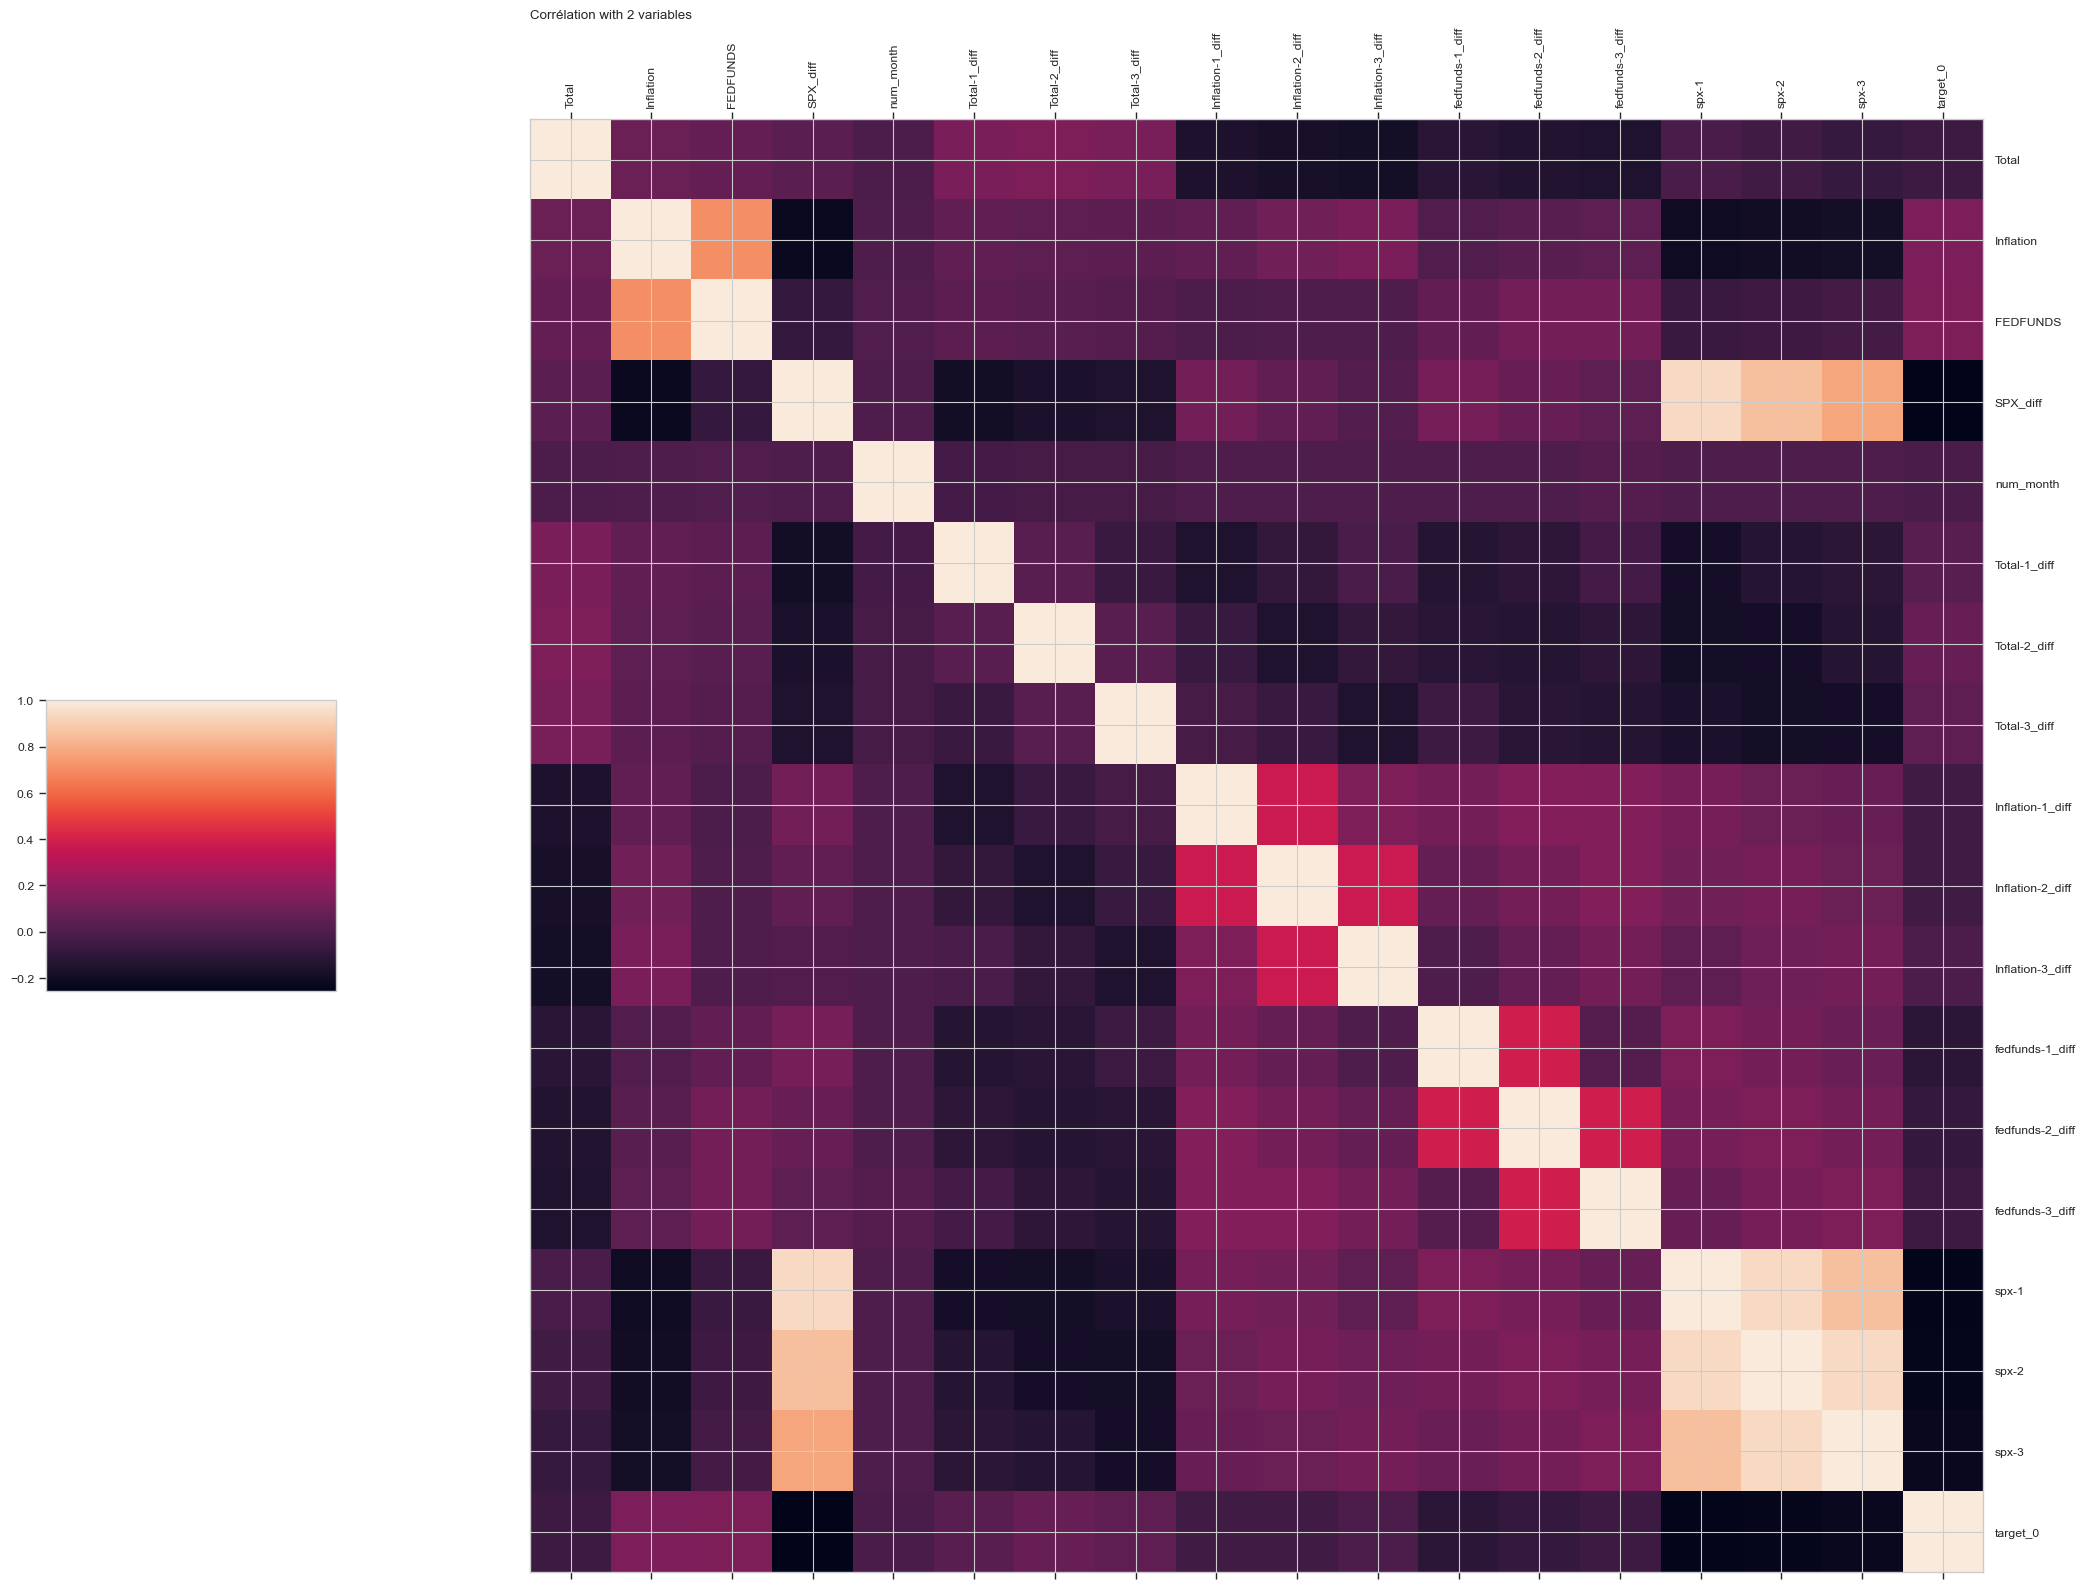

In [51]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None, size=25):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (size, size*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im, aspect=1/aspect, orientation='vertical', location="left")
    plt.show()


nb_plot = len(list_feat)
list_col_targets = [ f"target_{n_t}" for n_t in range(len(["class"]))]
list_col_corr = list_feat[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y


df_for_corr = pd.DataFrame(np.hstack((X, Y)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()

fig = plot_corr(corr_matrix)


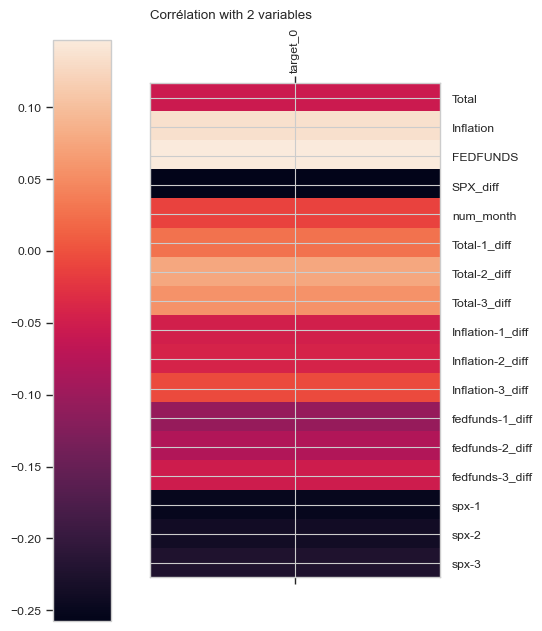

In [52]:
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

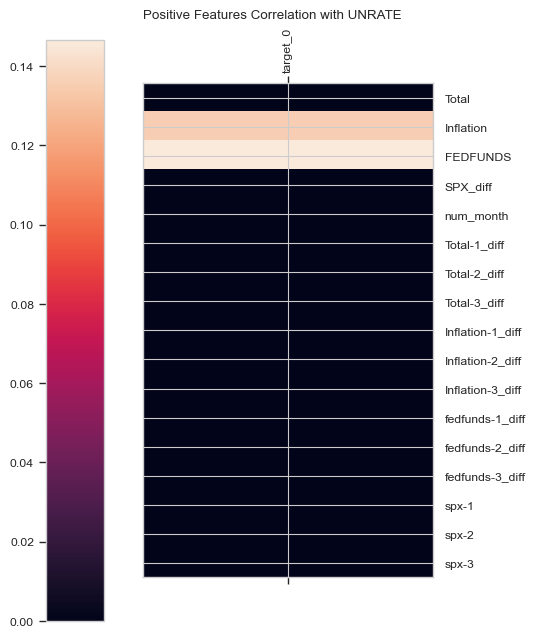

In [53]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets>0.1, 0),
    aspect=0.1, 
    size=5,
    title="Positive Features Correlation with UNRATE"
    )

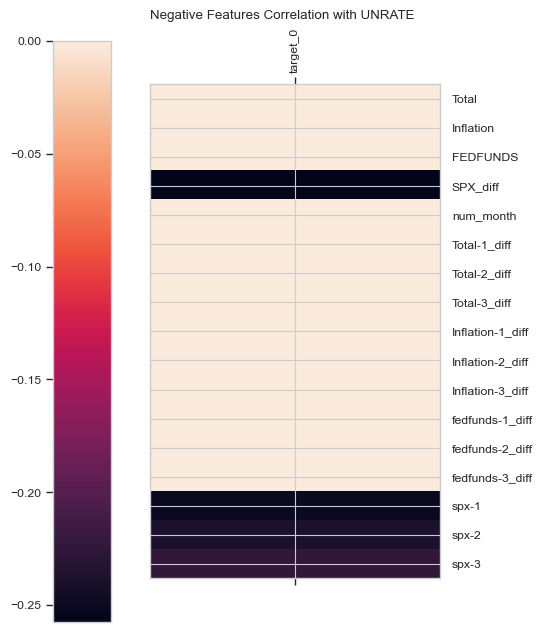

In [54]:
fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets < -0.15, 0),
    aspect=0.1, 
    size=5,
    title="Negative Features Correlation with UNRATE"
    )

In [55]:
corr_matrix_targets.where(corr_matrix_targets < -0.15, 0)

,target_0
Total,0.000000
Inflation,0.000000
FEDFUNDS,0.000000
SPX_diff,-0.257393
num_month,0.000000
Total-1_diff,0.000000
Total-2_diff,0.000000
Total-3_diff,0.000000
Inflation-1_diff,0.000000
Inflation-2_diff,0.000000


### on Total_diff

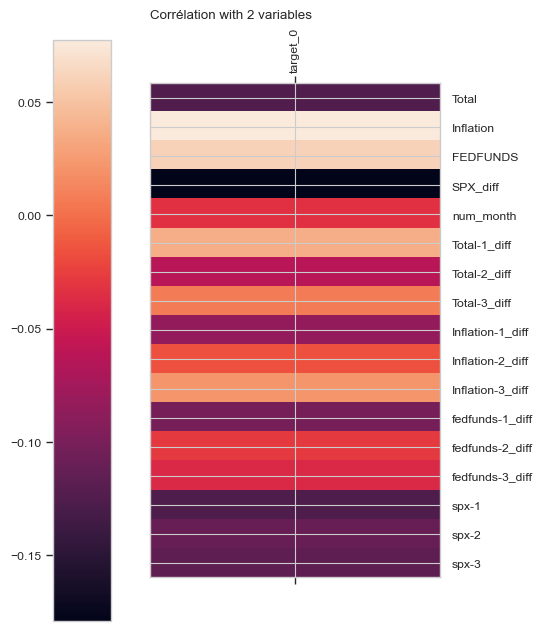

In [56]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["Total_diff"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ur_lower

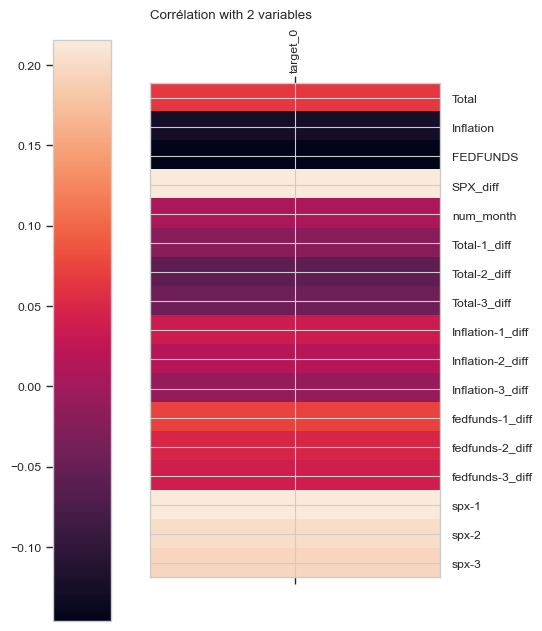

In [57]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ur_lower"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ur_stable

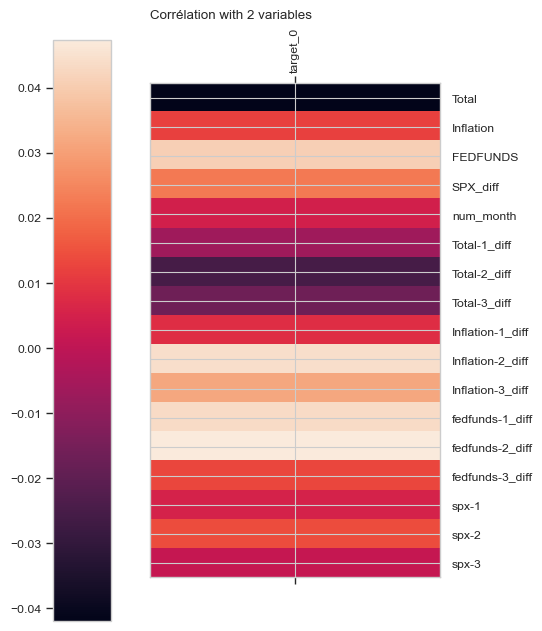

In [58]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ur_stable"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

### On ur_higher

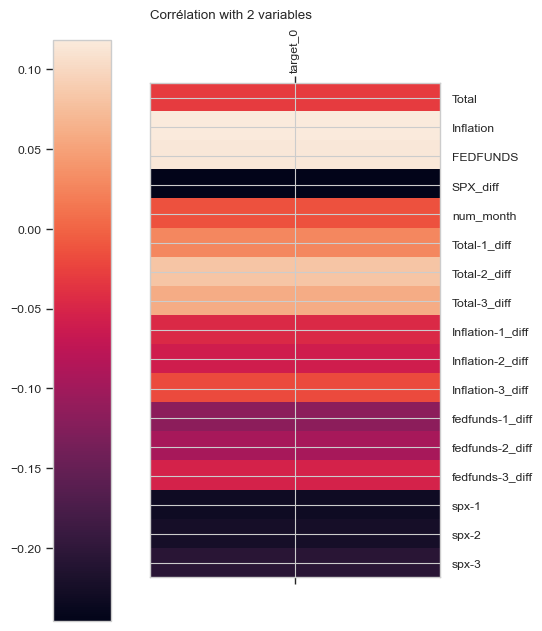

In [59]:
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df_for_corr = pd.DataFrame(np.hstack((X, df[df["TRAIN"] == 1 ]["ur_higher"].values.reshape(-1, 1))), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df_for_corr.corr()
corr_matrix_targets = corr_matrix.copy().loc[list_feat, list_col_targets]
fig = plot_corr(corr_matrix_targets, aspect=0.1, size=5)

## Train

### Test some models

In [60]:
from sklearn.base import clone
def choose_target(df_y, target, nb_test):
    print("\nTarget : ", target)
    arr_target = df_y[target].values
    ytrain = arr_target[:nb_test]
    ytest = arr_target[nb_test:]
    Y = ytrain.reshape(-1, 1)
    Y_test = ytest.reshape(-1, 1)
    return Y, Y_test


def fit_clf(clf, X, Y, X_test, Y_test, X_for_pred):
    clf.fit(X, Y)
    print("TRAIN score :", clf.score(X, Y))
    print("TEST score :", clf.score(X_test, Y_test))
    print("Next month : ", 
      clf.predict(X_for_pred),
      np.max(clf.predict_proba(X_for_pred)[0]),
    )
    return clf
    
def multi_target_fit(clf, df_y, nb_test, list_targets):
    list_clf = []
    for target in list_targets:
        Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
        new_clf = fit_clf(clone(clf), X, Y, X_test, Y_test, X_for_pred)
        list_clf.append(new_clf)
    return list_clf

In [61]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.6014580801944107
TEST score : 0.4
Next month :  [False] 0.5403433809993854

Target :  ur_stable
TRAIN score : 0.7496962332928311
TEST score : 0.7333333333333333
Next month :  [False] 0.7832399748056454

Target :  ur_higher
TRAIN score : 0.675577156743621
TEST score : 0.5333333333333333
Next month :  [False] 0.7097900868620662


In [62]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.46780072904009723
TEST score : 0.13333333333333333
Next month :  [0] 0.47170050124148305


In [63]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])

"""clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))"""


Target :  class
TRAIN score : 0.39003645200486026
TEST score : 0.3333333333333333
Next month :  [1] 0.7315697364243728


'clf.fit(X, Y)\nprint("TRAIN score :", clf.score(X, Y))\nprint("TEST score :", clf.score(X_test, Y_test))\nprint("Next month : ", clf.predict(X_for_pred))\nprint("classes : ", clf.classes_)\nprint("classes prob : ", clf.predict_proba(X_for_pred))'

In [64]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 1.0
TEST score : 0.26666666666666666
Next month :  [2] 1.0


In [65]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.5650060753341434
TEST score : 0.3333333333333333
Next month :  [0] 0.4685494576001107


In [66]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=0, loss="log_loss")
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.4313487241798299
TEST score : 0.4666666666666667
Next month :  [0] 0.5930376000082627


### KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.7800729040097205
TEST score : 0.7333333333333333
Next month :  [ True] 1.0

Target :  ur_stable
TRAIN score : 0.8080194410692588
TEST score : 0.7333333333333333
Next month :  [False] 1.0

Target :  ur_higher
TRAIN score : 0.7910085054678008
TEST score : 0.8
Next month :  [False] 1.0


Multi-class : 

In [68]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets=["class"])


Target :  class
TRAIN score : 0.5978128797083839
TEST score : 0.8
Next month :  [0] 0.8


### GradienBoost

one-by-one class :

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.9027946537059538
TEST score : 0.8666666666666667
Next month :  [False] 0.6797803760388993

Target :  ur_stable
TRAIN score : 0.8712029161603888
TEST score : 0.8
Next month :  [False] 0.7710096803260211

Target :  ur_higher
TRAIN score : 0.8784933171324423
TEST score : 0.4666666666666667
Next month :  [False] 0.8281108329761698


All classes : 

In [70]:
arr_proba_train = np.zeros((nb_test, len(list_targets)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets)))
# loop over clf
for i_clf, target in enumerate(list_targets):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# final accuracy
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values

from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))


Target :  ur_lower

Target :  ur_stable

Target :  ur_higher
Accuracy train :  0.8821385176184691
Accuracy test :  0.3333333333333333


Only first and second class : ur_lower and ur_stable :  

In [71]:
list_targets_red = list_targets[:2]
print(list_targets_red)
arr_proba_train = np.zeros((nb_test, len(list_targets_red)))
arr_proba_test = np.zeros((df_y.shape[0]-nb_test, len(list_targets_red)))
# loop over clf
for i_clf, target in enumerate(list_targets_red):
    clf_curr =  list_clf[i_clf]
    Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
    arr_proba_train[:,i_clf] = clf_curr.predict_proba(X)[:, np.argmax(clf_curr.classes_ == True)]
    arr_proba_test[:,i_clf] = clf_curr.predict_proba(X_test)[:, np.argmax(clf_curr.classes_ == True)]
# prediction , last class if other pred < 0.5
Y_pred = np.argmax(arr_proba_train, axis=1)
Y_pred[np.all(arr_proba_train < 0.5, axis=1)] = 2

Y_test_pred = np.argmax(arr_proba_test, axis=1)
Y_test_pred[np.all(arr_proba_test < 0.5, axis=1)] = 2

Y_multi = df_y.iloc[:nb_test]["class"].values
Y_multi_test = df_y.iloc[nb_test:]["class"].values
# final accuracy
from sklearn.metrics import accuracy_score
print("Accuracy train : ", accuracy_score(Y_multi, Y_pred))
print("Accuracy test : ", accuracy_score(Y_multi_test, Y_test_pred))

['ur_lower', 'ur_stable']

Target :  ur_lower

Target :  ur_stable
Accuracy train :  0.7922235722964763
Accuracy test :  0.6666666666666666


Multi-class : 

In [72]:
Y, Y_test = choose_target(df_y, target="class", nb_test=nb_test)
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))


Target :  class
TRAIN score : 0.905224787363305
TEST score : 0.4


In [73]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=1)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class
TRAIN score : 0.905224787363305
TEST score : 0.4
Next month :  [0] 0.5175071400991427


In [74]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=2)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)


Target :  class
TRAIN score : 0.8979343863912516
TEST score : 0.4
Next month :  [0] 0.5037598212369104


### MCP

Multi-class

In [75]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0)
list_clf = multi_target_fit(
    clf,
    df_y,
    nb_test,
    list_targets=["class"],
)
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.6743620899149453
TEST score : 0.5333333333333333
Next month :  [0] 0.37589442470806467
nb iteration :  200


In [76]:
clf = MLPClassifier(random_state=0, 
                    max_iter=1000,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.9428918590522479
TEST score : 0.6666666666666666
Next month :  [0] 0.6751355825017273
nb iteration :  1000


In [77]:
clf = MLPClassifier(random_state=0, 
                    max_iter=1500,
                    n_iter_no_change=1500)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.9890643985419199
TEST score : 0.5333333333333333
Next month :  [0] 0.8288396192507876
nb iteration :  1500


In [78]:
clf = MLPClassifier(hidden_layer_sizes=(4),
                    random_state=0, 
                    max_iter=48000,
                    n_iter_no_change=48000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.5504252733900364
TEST score : 0.5333333333333333
Next month :  [0] 0.4245317989010325
nb iteration :  48000


In [79]:
clf = MLPClassifier(hidden_layer_sizes=(8),
                    random_state=4, 
                    max_iter=40000,
                    n_iter_no_change=40000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.6245443499392467
TEST score : 0.4
Next month :  [0] 0.4008627948123794
nb iteration :  40000


In [80]:
from sklearn.neural_network import MLPClassifier
list_nb_iter = [1000, 2000, 4000, 8000, 16000, 32000]
list_random_state = [0, 1, 2, 3, 4]
list_nb_cell = [8, 16, 32, 64, 128, 256]
df_res = pd.DataFrame(columns=["nb_neurons", "nb_iter", "random_state", "accuracy", "accuracy_test"])
Y, Y_test = choose_target(df_y, "class", nb_test)
acc_best = 0
for nb_neurons in list_nb_cell:
    for nb_iter in list_nb_iter:
        for random_state in list_random_state:
            param = (nb_neurons, nb_iter, random_state)
            print(f"\nnb_neurons: {nb_neurons} , nb_iter: {nb_iter}, random_state: {random_state}")
            clf = MLPClassifier(
                hidden_layer_sizes=(nb_neurons),
                random_state=random_state, 
                max_iter=nb_iter,
                n_iter_no_change=nb_iter,
            )
            list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
            acc_curr = list_clf[0].score(X, Y)
            acc_curr_test = list_clf[0].score(X_test, Y_test)
            df_res = df_res.append(
                {
                    "nb_neurons": nb_neurons, 
                    "nb_iter": nb_iter, 
                    "random_state": random_state, 
                    "accuracy": acc_curr, 
                    "accuracy_test": acc_curr_test,
                }, 
                ignore_index=True,
            )

            if acc_curr_test > acc_best:
                acc_best = acc_curr_test
                param_best = param
                clf_best = list_clf[0]


print("new best param : ", param_best)
print("TRAIN score  best :", list_clf[0].score(X, Y))
print("TEST score best :", acc_best)
df_res


Target :  class

nb_neurons: 8 , nb_iter: 1000, random_state: 0

Target :  class
TRAIN score : 0.574726609963548
TEST score : 0.26666666666666666
Next month :  [1] 0.36069847550587386

nb_neurons: 8 , nb_iter: 1000, random_state: 1

Target :  class
TRAIN score : 0.5577156743620899
TEST score : 0.6666666666666666
Next month :  [0] 0.4498551463570214

nb_neurons: 8 , nb_iter: 1000, random_state: 2

Target :  class
TRAIN score : 0.5735115431348724
TEST score : 0.6
Next month :  [2] 0.3743415354514351

nb_neurons: 8 , nb_iter: 1000, random_state: 3

Target :  class
TRAIN score : 0.5820170109356014
TEST score : 0.6
Next month :  [2] 0.4136227737600784

nb_neurons: 8 , nb_iter: 1000, random_state: 4

Target :  class
TRAIN score : 0.5589307411907655
TEST score : 0.4
Next month :  [0] 0.40245902871825323

nb_neurons: 8 , nb_iter: 2000, random_state: 0

Target :  class
TRAIN score : 0.606318347509113
TEST score : 0.3333333333333333
Next month :  [1] 0.39745490047535903

nb_neurons: 8 , nb_iter

,nb_neurons,nb_iter,random_state,accuracy,accuracy_test
0,8.0,1000.0,0.0,0.574727,0.266667
1,8.0,1000.0,1.0,0.557716,0.666667
2,8.0,1000.0,2.0,0.573512,0.600000
3,8.0,1000.0,3.0,0.582017,0.600000
4,8.0,1000.0,4.0,0.558931,0.400000
...,...,...,...,...,...
175,256.0,32000.0,0.0,1.000000,0.400000
176,256.0,32000.0,1.0,1.000000,0.533333
177,256.0,32000.0,2.0,1.000000,0.666667
178,256.0,32000.0,3.0,1.000000,0.533333


In [81]:
df_res.to_csv(f"data/res_mlp_{ratio_test}.csv", index=False)

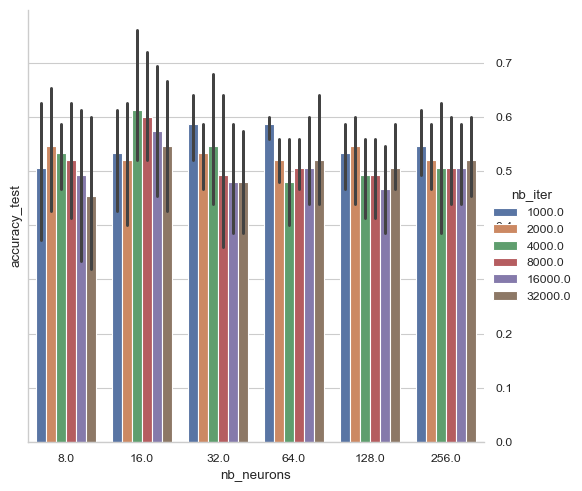

In [82]:
sns.catplot(data=df_res, kind="bar", x="nb_neurons", y="accuracy_test", hue="nb_iter")

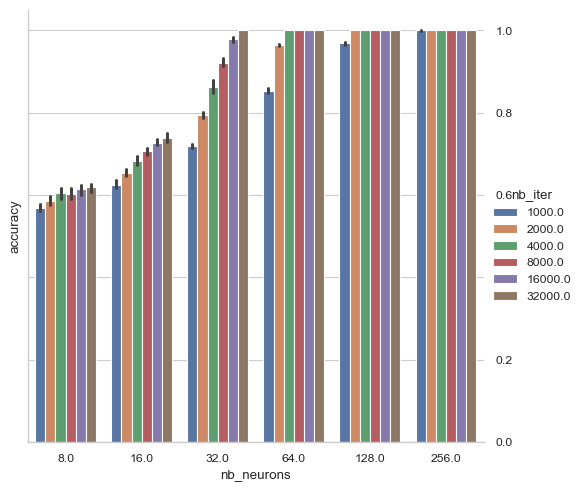

In [83]:
sns.catplot(data=df_res, kind="bar", x="nb_neurons", y="accuracy", hue="nb_iter")

In [92]:
df_res[df_res["accuracy_test"] > 0.7]

,nb_neurons,nb_iter,random_state,accuracy,accuracy_test
44,16.0,4000.0,4.0,0.686513,0.866667
49,16.0,8000.0,4.0,0.712029,0.800000
54,16.0,16000.0,4.0,0.739976,0.733333
59,16.0,32000.0,4.0,0.748481,0.733333
73,32.0,4000.0,3.0,0.854192,0.800000
78,32.0,8000.0,3.0,0.914945,0.733333
116,64.0,32000.0,1.0,1.000000,0.733333


for param best :  (16, 4000, 4)


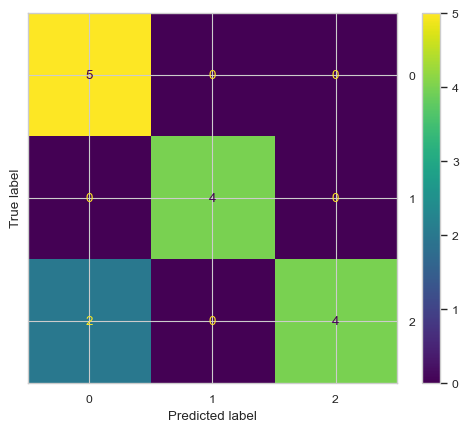

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print("for param best : ", param_best)
predictions = clf_best.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=clf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_best.classes_)
disp.plot()
plt.show()

In [113]:
clf = MLPClassifier(
    hidden_layer_sizes=(16),
    random_state=4,
    max_iter=4000,
    n_iter_no_change=4000,
    alpha=0.0001,
)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])


Target :  class
TRAIN score : 0.6865127582017011
TEST score : 0.8666666666666667
Next month :  [0] 0.3580796794794029


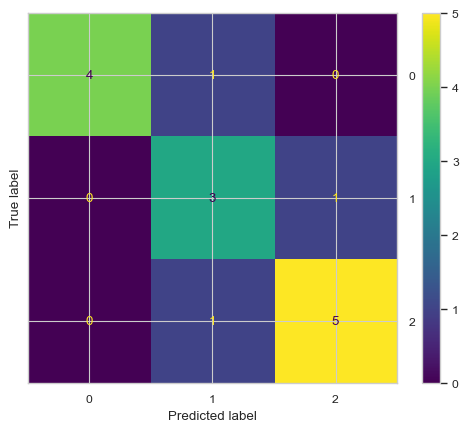

In [112]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.show()

In [88]:
clf = MLPClassifier(hidden_layer_sizes=(16),
                    random_state=1, 
                    max_iter=1000,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, ["class"])
print("nb iteration : ", list_clf[-1].n_iter_)


Target :  class
TRAIN score : 0.6075334143377886
TEST score : 0.5333333333333333
Next month :  [1] 0.5128052760713334
nb iteration :  1000


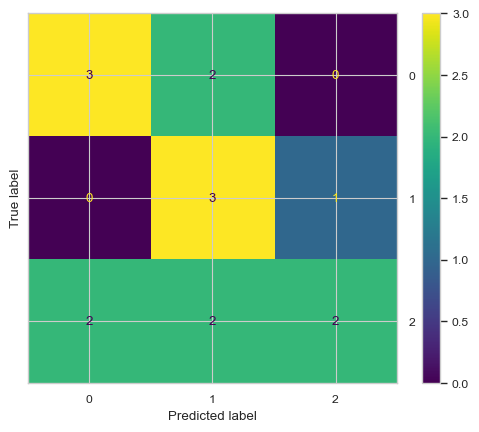

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = list_clf[0].predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=list_clf[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list_clf[0].classes_)
disp.plot()
plt.show()

In [90]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, 
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.6561360874848117
TEST score : 0.6666666666666666
Next month :  [False] 0.5762379465936085

Target :  ur_stable
TRAIN score : 0.7484811664641555
TEST score : 0.7333333333333333
Next month :  [False] 0.7056648651632249

Target :  ur_higher
TRAIN score : 0.7132442284325637
TEST score : 0.6
Next month :  [False] 0.6706974193738885
